<a href="https://colab.research.google.com/github/tmathema/Employee_reviews_NLP/blob/main/data_preprocessing_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive  
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
# uploading the data
data = pd.read_csv("/content/drive/MyDrive/x_consulting/reviews.csv")

In [ ]:
data.isna().sum()

Unnamed: 0                  0
column_label                0
firm                        0
date_review                 0
job_title                   0
current                     0
location               297338
overall_rating              0
work_life_balance      149894
culture_values         191373
diversity_inclusion    702500
career_opp             147501
comp_benefits          150082
senior_mgmt            155876
recommend                   0
ceo_approv                  0
outlook                     0
headline                 2219
pros                        0
cons                        8
use                    838566
dtype: int64

In [ ]:
cols = ['headline', 'cons', 'pros']
data['text']= data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [ ]:
data=data.dropna(subset=['headline', 'cons'])

In [ ]:
#indices haing incorrect ratings based on 3 column sentiments
data = data.drop([5987, 66997,14667, 12282, 30322, 72287, 72287], axis = 0)

In [ ]:
import collections
from pathlib import Path
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 10030000

In [ ]:
def get_group(df, category_col, category):
    """
    Returns documents of a single category
    
    Arguments:
        df: pandas dataframe of documents
        category_col: str, column name corresponding to categories or clusters
        category: int, cluster number to return
    Returns:
        single_category: pandas dataframe with documents from a single category
    """
    
    single_category = df[df[category_col]==category].reset_index(drop=True)

    return single_category 

In [ ]:
def most_common(lst, n_words):
    """
    Get most common words in a list of words
    
    Arguments:
        lst: list, each element is a word
        n_words: number of top common words to return
    
    Returns:
        counter.most_common(n_words): counter object of n most common words
    """
    counter=collections.Counter(lst)
    return counter.most_common(n_words)

In [ ]:
def extract_labels(category_docs, print_word_counts=True):
    """
    Extract labels from documents in the same cluster by concatenating
    most common verbs, objects, and nouns

    Argument:
        category_docs: list of documents, all from the same category or
                       clustering
        print_word_counts: bool, True will print word counts of each type in this category

    Returns:
        label: str, group label derived from concatentating most common
               verb, object, and two most common nouns

    """

    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to 
    # running lists for whole cluster
    for i in range(len(category_docs)):
        doc = nlp(category_docs[i])
        for token in doc:
            if token.is_stop==False:
                if token.dep_ == 'ROOT':
                    verbs.append(token.text.lower())

                elif token.dep_=='dobj':
                    dobjs.append(token.lemma_.lower())

                elif token.pos_=='NOUN':
                    nouns.append(token.lemma_.lower())
                    
                elif token.pos_=='ADJ':
                    adjs.append(token.lemma_.lower())

    # for printing out for inspection purposes
    if print_word_counts:
        for word_lst in [verbs]:
            counter=collections.Counter(word_lst)
            counter_verbs = counter

        for word_lst in [dobjs]:
            counter=collections.Counter(word_lst)
            counter_dobjs = counter

        for word_lst in [nouns]:
            counter=collections.Counter(word_lst)
            counter_nouns = counter
        
        for word_lst in [adjs]:
            counter=collections.Counter(word_lst)
            counter_adjs = counter
    
    # take most common words of each form
    if len(verbs) > 0:
        verb = most_common(verbs, 1)[0][0]
    
    if len(dobjs) > 0:
        dobj = most_common(dobjs, 1)[0][0]
    
    if len(nouns) > 0:
        noun1 = most_common(nouns, 1)[0][0]
    
    if len(set(nouns)) > 1:
        noun2 = most_common(nouns, 2)[1][0]
    
    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)
    
    if '' in label_words:
        label_words.remove('')
    
    label = '_'.join(label_words)
    
    return label, counter_verbs, counter_dobjs, counter_nouns, counter_adjs

In [ ]:
def apply_and_summarize_labels(df, category_col):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """
    
    numerical_labels = df[category_col].unique()
    
    # create dictionary of the numerical category to the generated label
    label_dict = {}
    for label in numerical_labels:
        current_category = list(get_group(df, category_col, label)['text'])
        label_dict[label] = extract_labels(current_category)
        
    # create summary dataframe of numerical labels and counts
    summary_df = (df.groupby(category_col)['text'].count()
                    .reset_index()
                    .rename(columns={'text':'count'})
                    .sort_values('count', ascending=False))
    
    # apply generated labels
    summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]], axis = 1)
    
    return summary_df

In [ ]:
example_category = list(get_group(data, 'overall_rating', 1)['headline'])
k = extract_labels(example_category, True)

In [ ]:
bag = pd.DataFrame.from_dict(k[4], orient='index').reset_index()
d = {}
for a, x in bag.values:
  d[a] = x

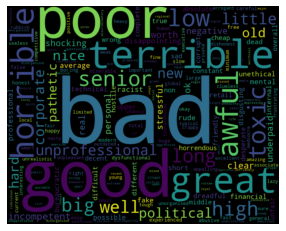

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1000, height=800)
wordcloud.generate_from_frequencies(d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
example_category = list(get_group(data, 'overall_rating', 2)['headline'])
k = extract_labels(example_category, True)

In [ ]:
bag = pd.DataFrame.from_dict(k[4], orient='index').reset_index()
d = {}
for a, x in bag.values:
  d[a] = x

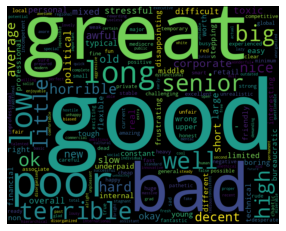

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1000, height=800)
wordcloud.generate_from_frequencies(d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
example_category = list(get_group(data, 'overall_rating', 3)['headline'])
k = extract_labels(example_category, True)

In [ ]:
bag = pd.DataFrame.from_dict(k[4], orient='index').reset_index()
d = {}
for a, x in bag.values:
  d[a] = x

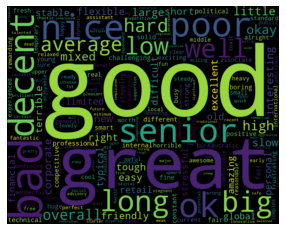

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1000, height=800)
wordcloud.generate_from_frequencies(d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
example_category = list(get_group(data, 'overall_rating', 4)['headline'])
k = extract_labels(example_category, True)

In [ ]:
bag = pd.DataFrame.from_dict(k[4], orient='index').reset_index()
d = {}
for a, x in bag.values:
  d[a] = x

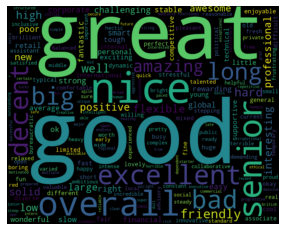

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1000, height=800)
wordcloud.generate_from_frequencies(d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
example_category = list(get_group(data, 'overall_rating', 5)['headline'])
k = extract_labels(example_category, True)

In [ ]:
bag = pd.DataFrame.from_dict(k[4], orient='index').reset_index()
d = {}
for a, x in bag.values:
  d[a] = x

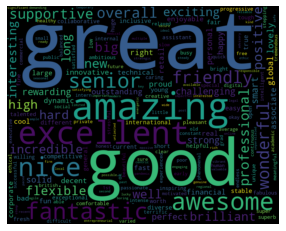

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1000, height=800)
wordcloud.generate_from_frequencies(d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(data.headline)
#vector = vectorizer.transform(Y.Author_)
word_dictionary = vectorizer.vocabulary_

In [ ]:
from nltk.util import ngrams

def get_ngrams(text, n=2):
    text = str(text)
    n_grams = ngrams(text.split(), n)
    returnVal = []
    
    try:
        for grams in n_grams:
            returnVal.append('_'.join(grams))
    except(RuntimeError):
        pass
        
    return ' '.join(returnVal).strip()

In [ ]:
rating_1 = data[data['overall_rating'].isin([1,2])]

In [ ]:
rating_1  = rating_1[rating_1.headline.str.contains('great', 'good')]

In [ ]:
rating_1["bigram_text_headline"] = rating_1["headline"].apply(get_ngrams, n=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
rating_1=rating_1.dropna(subset=['bigram_text_headline'])

In [ ]:
headline_list = rating_1["bigram_text_headline"].tolist()
headline_string = ' '.join(headline_list)

In [ ]:
from wordcloud import WordCloud   # for the wordcloud
wordcloud = WordCloud(width = 2000, height = 1334, random_state=1, 
                      background_color='black', colormap='Pastel1', max_words = 75, collocations=False, 
                      normalize_plurals=False).generate(headline_string)

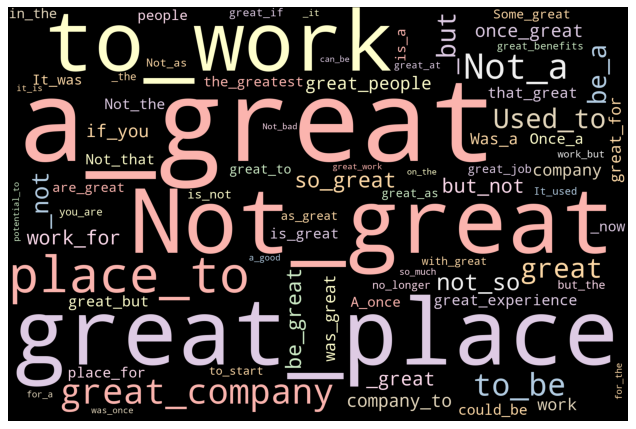

In [ ]:
# create the wordcloud
import matplotlib.pyplot as plt   # for wordclouds & charts
from matplotlib.pyplot import figure

# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(10, 10), dpi=80)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 
   
#Plot
plot_cloud(wordcloud)

In [ ]:
# Replace String using apply() function with lambda.
data = data.apply(lambda x: x.replace({'Not great':'not_great', 'Not a great':'not_a_great', 'not great':'not_great', 'not a great':'not_a_great',
                                       'not so great': 'not_so_great', 'Not so great': 'not_so_great', 'Once a great': 'once_a_great', 
                                       'once a great': 'once_a_great', 'once great': 'once_great', 'was great':'was_great', 
                                       'Was great':'was_great','Was a great':'was_a_great', 'Used to be great': 'used_to_begreat', 
                                       'Not a good': 'not_a_good', 'not a good': 'not_a_good', 'Not so great': 'not_so_good', 'Can be great': 'can_be_great',
                                       'Used to be a great': 'used_to_be_a_great', 'used to be a great': 'used_to_be_a_great',
                                       'Not the greatest':'not_great', 'not the greatest':'not_great', 'Once-great': 'once_great',
                                       'Used to be good':'used_to_be_good', 'Used to be great':'used_to_be_great',
                                       'Not so good': 'not_so_good', 'Not good':'not_good', 'NOT a good': 'not_a_good', 'No good': 'no_good',
                                       'not good': 'not_good', 'not very good': 'not_very_good', 'Not that good': 'not_that_good', 'nothing good': 'nothing_good'}, regex=True))

In [ ]:
cols = ['headline','cons', 'pros']
data['text']= data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [ ]:
data['len_text'] = data['text'].str.split().map(lambda x: len(x))

In [ ]:
data.len_text.describe()

count    836333.000000
mean         39.840957
std          51.722717
min           6.000000
25%          16.000000
50%          23.000000
75%          45.000000
max        3224.000000
Name: len_text, dtype: float64

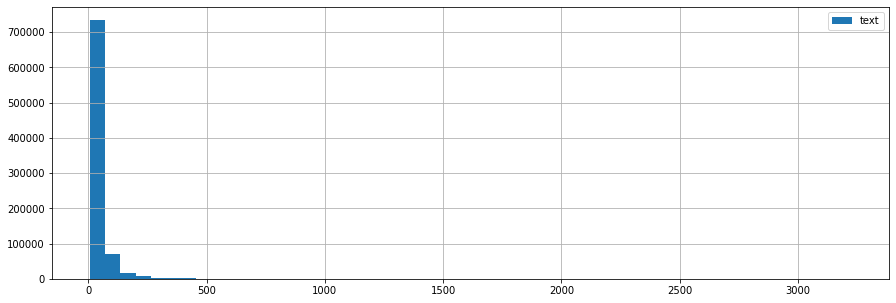

In [ ]:
data['text'].str.split().map(lambda x: len(x)).hist(bins=50, figsize=(15,5), legend=True)

In [ ]:
data = data[data['len_text']<150]
data.shape

(811368, 23)

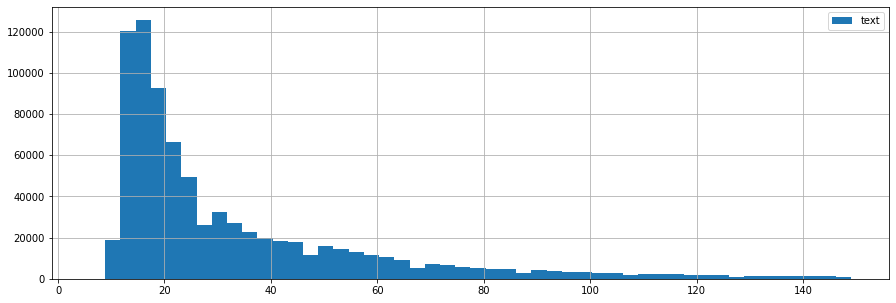

In [ ]:
data['text'].str.split().map(lambda x: len(x)).hist(bins=50, figsize=(15,5), legend=True)

In [ ]:
#undersampling the dataset to make it balanced
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
X_data_balanced, y_data_balanced = under_sampler.fit_resample(data[['text']], data['overall_rating'])
print(f"Training target statistics: {Counter(X_data_balanced)}")
print(f"Training target statistics: {Counter(y_data_balanced)}")

Training target statistics: Counter({'text': 1})
Training target statistics: Counter({1: 51877, 2: 51877, 3: 51877, 4: 51877, 5: 51877})


In [ ]:
X_data_balanced.to_pickle("/content/drive/MyDrive/x_consulting/X_data_balanced.pkl")

In [ ]:
y_data_balanced.to_pickle("/content/drive/MyDrive/x_consulting/y_data_balanced.pkl")